In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [11]:
ticker = "NVDA" 
start_date = "2019-11-25"
end_date = "2024-12-18"
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [17]:
data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2019-11-25,5.503102,5.530250,5.535250,5.388000,5.401000,506476000
2019-11-26,5.398370,5.425000,5.517250,5.418500,5.512500,385244000
2019-11-27,5.433222,5.456000,5.501250,5.429500,5.466750,215784000
2019-11-29,5.395879,5.418500,5.453500,5.394500,5.425000,141556000
2019-12-02,5.209410,5.231250,5.425000,5.216000,5.411500,372036000
...,...,...,...,...,...,...
2024-12-11,139.309998,139.309998,140.169998,135.210007,137.360001,184905200
2024-12-12,137.339996,137.339996,138.440002,135.800003,137.080002,159211400


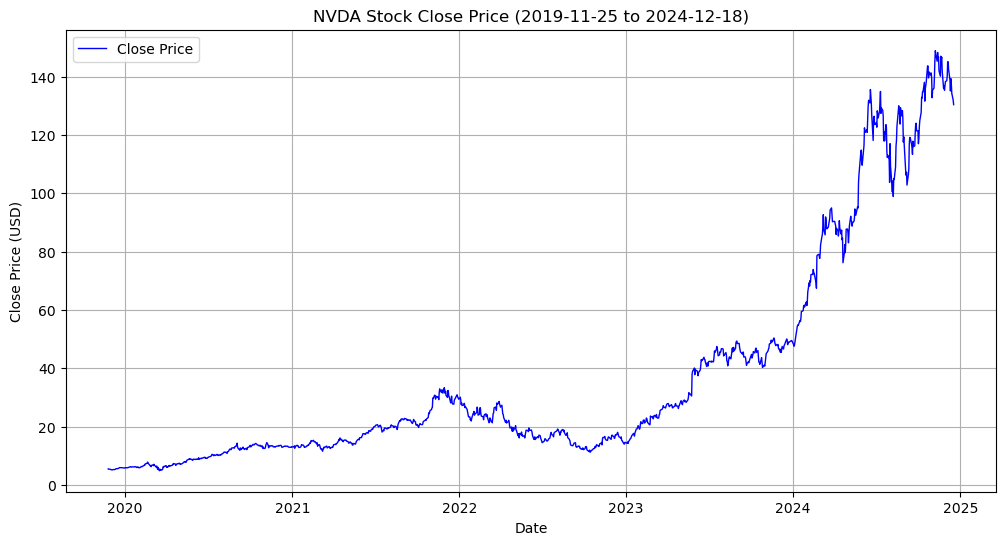

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

In [20]:
data_copy = data['Close'].values.reshape(-1, 1)

In [21]:
data_copy

array([[  5.53025007],
       [  5.42500019],
       [  5.45599985],
       ...,
       [134.25      ],
       [132.        ],
       [130.38999939]])